# Epidemic spread over the flights network

David Diener (19-733-179)
Kevin Kindler (15-922-529)
Layla Husselman (17-733-130)
Rafael Dubach (18-755-140)


## Dataset

https://networks.skewed.de/net/openflights 

https://ipywidgets.readthedocs.io/en/stable/

| **Name**              | **Description**                                                                                                                                                                                                                        |
|-----------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Airport ID            | Unique OpenFlights identifier for this airport.                                                                                                                                                                                        |
| Name                  | Name of airport. May or may not contain the City name.                                                                                                                                                                                 |
| City                  | Main city served by airport. May be spelled differently from Name.                                                                                                                                                                     |
| Country               | Country or territory where airport is located. See Countries to cross-reference to ISO 3166-1 codes.                                                                                                                                   |
| IATA                  | 3-letter IATA code. Null if not assigned/unknown.                                                                                                                                                                                      |
| ICAO                  | 4-letter ICAO code. Null if not assigned.                                                                                                                                                                                              |
| -                     | -                                                                                                                                                                                                                                      |
| Latitude              | Decimal degrees, usually to six significant digits. Negative is South, positive is North.                                                                                                                                              |
| Longitude             | Decimal degrees, usually to six significant digits. Negative is West, positive is East.                                                                                                                                                |
| Altitude              | In feet.                                                                                                                                                                                                                               |
| Timezone              | Hours offset from UTC. Fractional hours are expressed as decimals, eg. India is 5.5.                                                                                                                                                   |
| DST                   | Daylight savings time. One of E (Europe), A (US/Canada), S (South America), O (Australia), Z (New Zealand), N (None) or U (Unknown). See also: Help: Time                                                                              |
| Tz database time zone | Timezone in "tz" (Olson) format, eg. "America/Los_Angeles".                                                                                                                                                                            |
| Type                  | Type of the airport. Value "airport" for air terminals, "station" for train stations, "port" for ferry terminals and "unknown" if not known. In airports.csv, only type=airport is included.                                           |
| Source                | Source of this data. "OurAirports" for data sourced from OurAirports, "Legacy" for old data not matched to OurAirports (mostly DAFIF), "User" for unverified user contributions. In airports.csv, only source=OurAirports is included. |


## Standard stuff

##### Imports

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import collections
from IPython.display import Image
import matplotlib as mpl

# Worldmap
from libpysal import weights, examples
from libpysal.cg import voronoi_frames
from contextily import add_basemap
import geopandas
from shapely.geometry import Point
import fiona
import cartopy.crs as ccrs


##### Data

In [2]:
edges = pd.read_csv('edges.csv',sep=',')
nodes = pd.read_csv('nodes.csv',sep=',')
#print(edges.head())

##### Create directed graph

In [3]:
G = nx.DiGraph()
G.add_nodes_from(nodes['# index'])

#g.add_edges_from(edges['# source'],edges['target'], bipartite=0)

for a,b in edges.iterrows():
    if G.has_edge(b['# source'], b[' target']):
        G[b['# source']][b[' target']]['weight'] += 0.1
    else:
        G.add_edge(b['# source'], b[' target'], weight=0.1)
    #g.add_edges_from([(b['# source'], b[' target'])])
    #g.add_weighted_edges_from([(b['# source'], b[' target'], b[' weight'])])

##### Create undirected graph

In [4]:
GU = nx.Graph()
GU.add_nodes_from(nodes['# index'])

#g.add_edges_from(edges['# source'],edges['target'], bipartite=0)

for a,b in edges.iterrows():
    if GU.has_edge(b['# source'], b[' target']):
        GU[b['# source']][b[' target']]['weight'] += 0.1
    else:
        GU.add_edge(b['# source'], b[' target'], weight=0.1)
    #g.add_edges_from([(b['# source'], b[' target'])])
    #g.add_weighted_edges_from([(b['# source'], b[' target'], b[' weight'])])

#### Create Airport Dictionary

In [31]:
airport_dict = {}
for el in nodes.iterrows():
    airport_dict[el[1][' id']] = el[1][' name']

In [5]:
G[4][0]["weight"]
G.get_edge_data(4,0)

{'weight': 0.2}

In [6]:
print(nx.average_clustering(G))

0.4782853255477226


# Standard Calculations

### Directed Graph

##### Graph connectivity

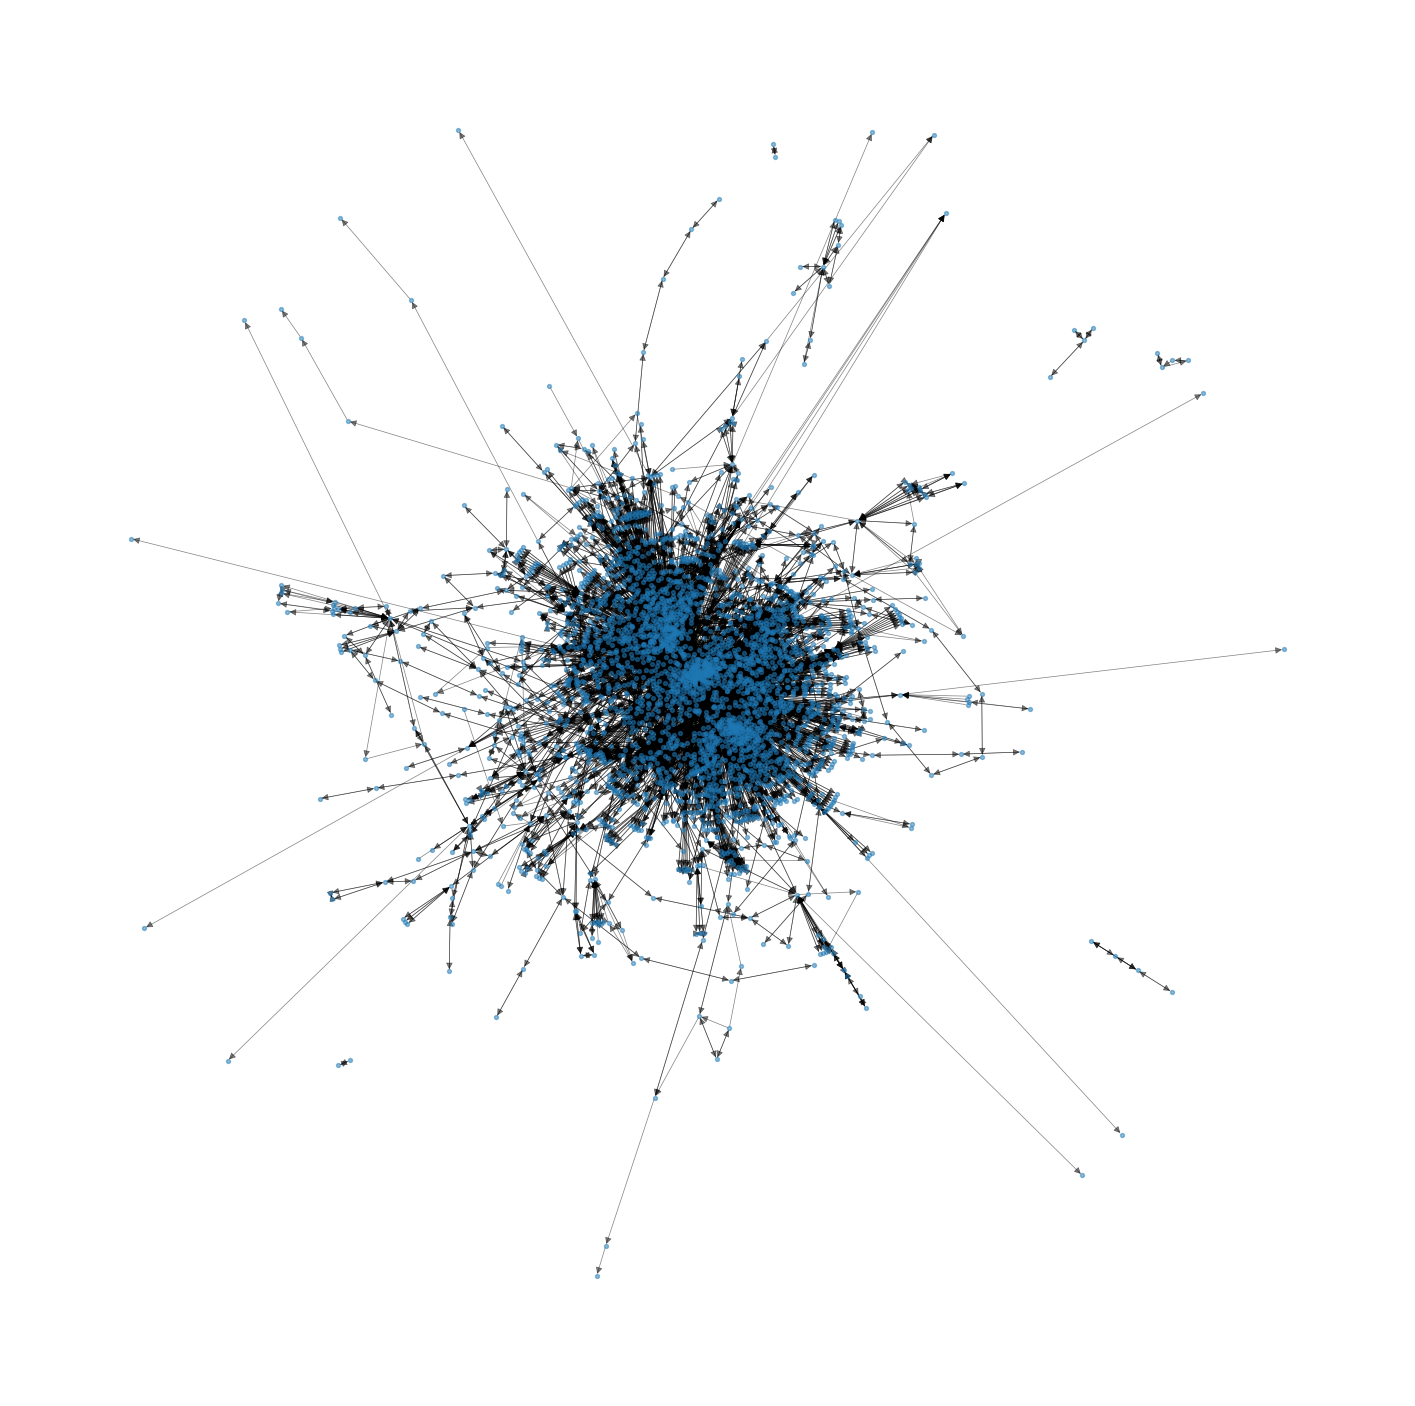

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(18, 18))
nx.draw_networkx(G, ax=ax, node_size=8, alpha=.5,
                 width=.5, with_labels=False)
ax.set_axis_off()

In [8]:
# Basic calculations
degree = nx.degree(G)
degree_hist = nx.degree_histogram(G)
density = nx.density(G)
clustering = nx.average_clustering(G)
num_nodes = nx.number_of_nodes(G)
num_edges = nx.number_of_edges(G)
average_degree = sum(degree_hist) / len(degree_hist)
max_weight = max([G[u][v]['weight'] for u,v in G.edges()])
print(max_weight)

2.0000000000000004


#### Analysis of the directed graph

In [21]:
# 1885, 1809, distance, 3378, 1, E75 CR7, 0
print(max(dict(G.edges).items(), key=lambda x: x[1]['weight']))

((1885, 1809), {'weight': 2.0000000000000004})


### Undirected Graph

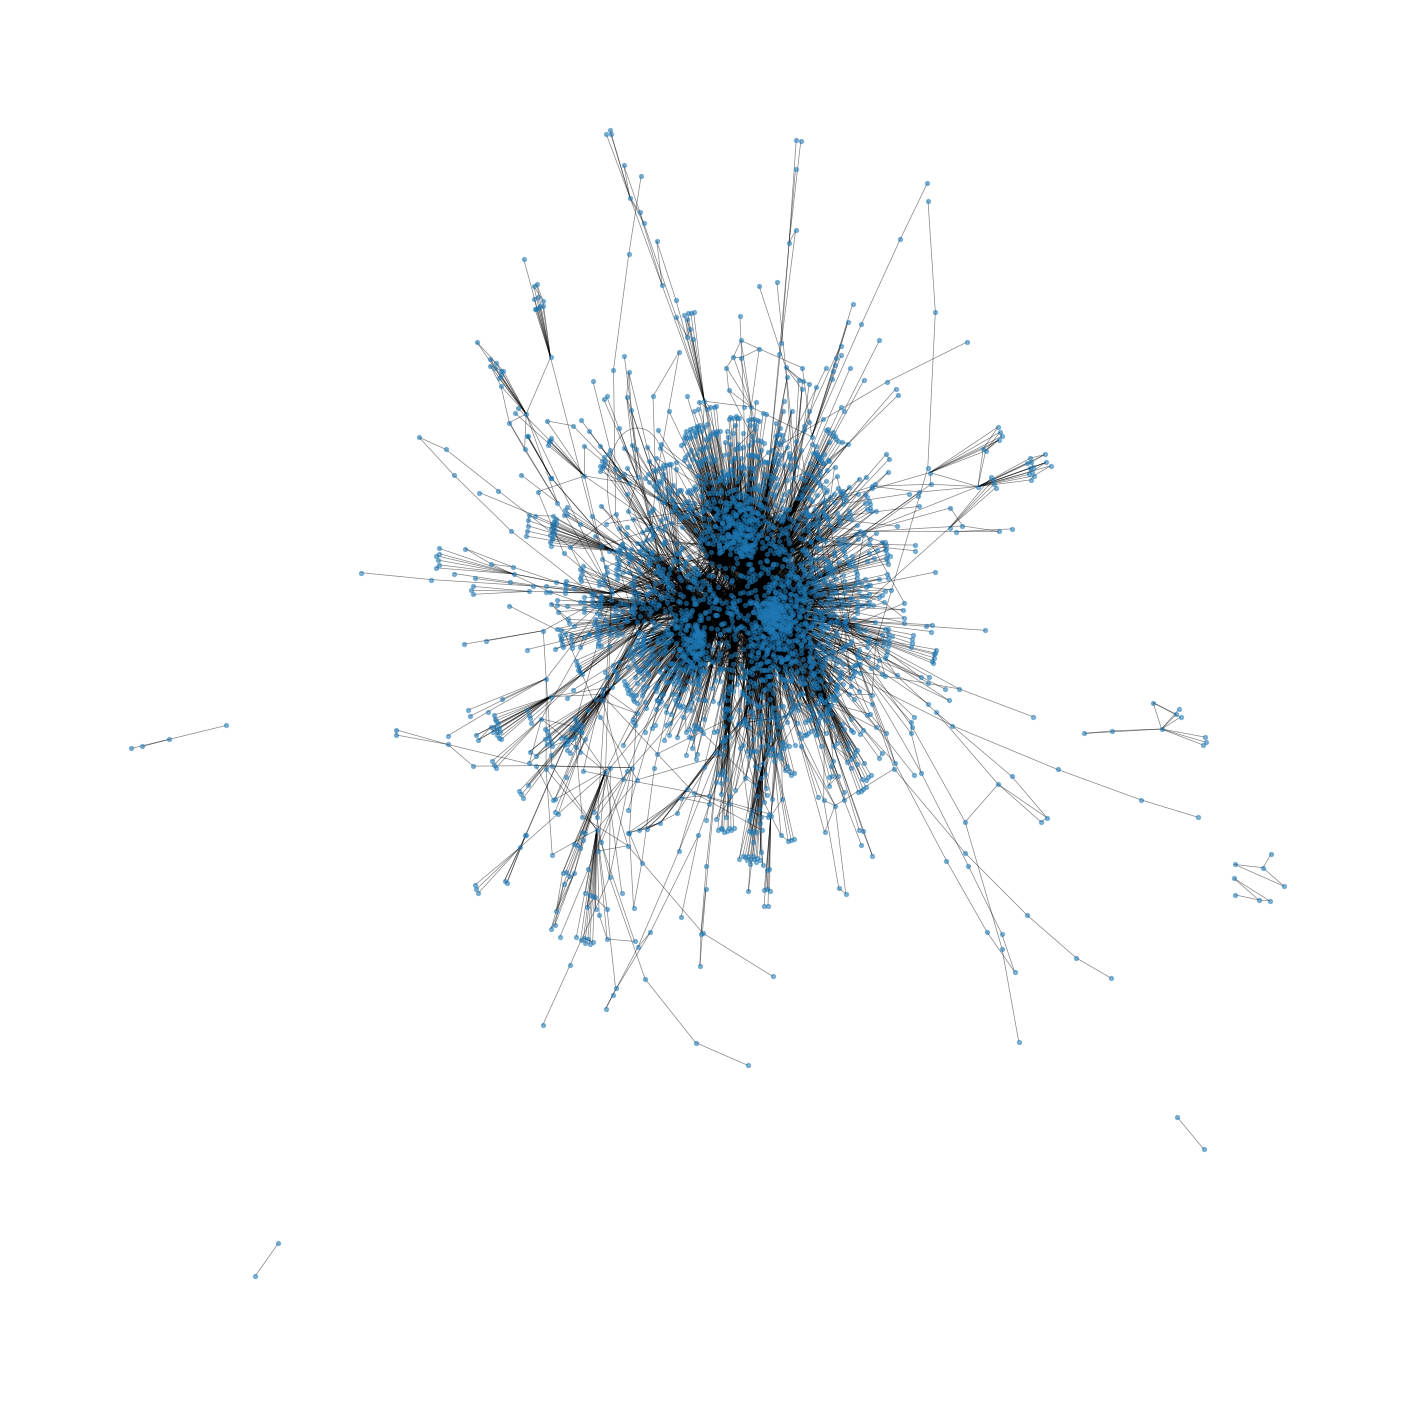

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(18, 18))
nx.draw_networkx(GU, ax=ax, node_size=8, alpha=.5,
                 width=.5, with_labels=False)
ax.set_axis_off()

In [10]:
# Basic calculations
degree = nx.degree(GU)
degree_hist = nx.degree_histogram(GU)
density = nx.density(GU)
clustering = nx.average_clustering(GU)
num_nodes = nx.number_of_nodes(GU)
num_edges = nx.number_of_edges(GU)
num_connected_components = nx.number_connected_components(GU)
average_degree = sum(degree_hist) / len(degree_hist)
max_weight = max([GU[u][v]['weight'] for u,v in GU.edges()])
print(max_weight)

3.900000000000002


#### Analysis of the undirected graph

In [20]:
print(max(dict(GU.edges).items(), key=lambda x: x[1]['weight']))


((1809, 1885), {'weight': 3.900000000000002})


# Map

Did not work out as expected, but please do not remove it since it could be helpful

In [11]:
"""
df = pd.read_csv('nodes.csv')
df.columns = [c.replace(' ', '') for c in df.columns]
pos = {airport: (df.longitude, df.latitude) for airport, df in df.iterrows()}
"""

"\ndf = pd.read_csv('nodes.csv')\ndf.columns = [c.replace(' ', '') for c in df.columns]\npos = {airport: (df.longitude, df.latitude) for airport, df in df.iterrows()}\n"

In [12]:
"""
largest_cc = list(GU.subgraph(c) for c in nx.connected_components(GU))[0]
print(largest_cc)
deg = nx.degree(largest_cc)
sizes = [5 * deg[iata] for iata in largest_cc.nodes]
"""

'\nlargest_cc = list(GU.subgraph(c) for c in nx.connected_components(GU))[0]\nprint(largest_cc)\ndeg = nx.degree(largest_cc)\nsizes = [5 * deg[iata] for iata in largest_cc.nodes]\n'

In [13]:
"""
def display_map(graph, node_color=None):
    # Map projection
    fig, ax = plt.subplots(
        1, 1, figsize=(36, 24),
        subplot_kw=dict(projection=ccrs.PlateCarree()))
    ax.coastlines()

    # Extent of continental US.
    #ax.set_extent([-128, -62, 20, 50])
    nx.draw_networkx(graph, ax=ax,
                     font_size=20,
                     alpha=.5,
                     width=.075,
                     node_size=sizes,
                     #labels=labels,
                     pos=pos,
                     node_color=node_color)
"""

'\ndef display_map(graph, node_color=None):\n    # Map projection\n    fig, ax = plt.subplots(\n        1, 1, figsize=(36, 24),\n        subplot_kw=dict(projection=ccrs.PlateCarree()))\n    ax.coastlines()\n\n    # Extent of continental US.\n    #ax.set_extent([-128, -62, 20, 50])\n    nx.draw_networkx(graph, ax=ax,\n                     font_size=20,\n                     alpha=.5,\n                     width=.075,\n                     node_size=sizes,\n                     #labels=labels,\n                     pos=pos,\n                     node_color=node_color)\n'

In [14]:
"""
display_map(largest_cc)
"""

'\ndisplay_map(largest_cc)\n'

In [15]:
"""
df = pd.read_csv('nodes.csv')
#print(df.keys())
df.columns = [c.replace(' ', '') for c in df.columns]
#print(df.keys())

geometry = [Point(latitudelongitude) for latitudelongitude in zip(df.latitude, df.longitude)]
#crs = {'init': 'epsg:2263'} #http://www.spatialreference.org/ref/epsg/2263/
#geo_df = geopandas.GeoDataFrame(df, crs=crs, geometry=geometry)

#geo_df.to_file(driver='ESRI Shapefile', filename='data.shp')

#print(geometry)
"""

"\ndf = pd.read_csv('nodes.csv')\n#print(df.keys())\ndf.columns = [c.replace(' ', '') for c in df.columns]\n#print(df.keys())\n\ngeometry = [Point(latitudelongitude) for latitudelongitude in zip(df.latitude, df.longitude)]\n#crs = {'init': 'epsg:2263'} #http://www.spatialreference.org/ref/epsg/2263/\n#geo_df = geopandas.GeoDataFrame(df, crs=crs, geometry=geometry)\n\n#geo_df.to_file(driver='ESRI Shapefile', filename='data.shp')\n\n#print(geometry)\n"

In [16]:
"""
# https://networkx.org/documentation/stable/auto_examples/geospatial/plot_delaunay.html
df = pd.read_csv('nodes.csv')
print(df.head())
df.columns = [c.replace(' ', '') for c in df.columns]
coordinates = np.column_stack((df.latitude, df.longitude))
cells, generators = voronoi_frames(coordinates, clip=None)
#cells, generators = voronoi_frames(coordinates, clip="convex hull")
delaunay = weights.Rook.from_dataframe(cells)
delaunay_graph = delaunay.to_networkx()
positions = dict(zip(delaunay_graph.nodes, coordinates))
ax = cells.plot(facecolor="lightblue", alpha=0.10, edgecolor="cornsilk", linewidth=1)
add_basemap(ax, source="world.tif") #hereee!!!!
ax.axis("off")
nx.draw(
    delaunay_graph,
    positions,
    ax=ax,
    node_size=2,
    node_color="k",
    edge_color="k",
    alpha=0.8,
)
plt.show()
"""


'\n# https://networkx.org/documentation/stable/auto_examples/geospatial/plot_delaunay.html\ndf = pd.read_csv(\'nodes.csv\')\nprint(df.head())\ndf.columns = [c.replace(\' \', \'\') for c in df.columns]\ncoordinates = np.column_stack((df.latitude, df.longitude))\ncells, generators = voronoi_frames(coordinates, clip=None)\n#cells, generators = voronoi_frames(coordinates, clip="convex hull")\ndelaunay = weights.Rook.from_dataframe(cells)\ndelaunay_graph = delaunay.to_networkx()\npositions = dict(zip(delaunay_graph.nodes, coordinates))\nax = cells.plot(facecolor="lightblue", alpha=0.10, edgecolor="cornsilk", linewidth=1)\nadd_basemap(ax, source="world.tif") #hereee!!!!\nax.axis("off")\nnx.draw(\n    delaunay_graph,\n    positions,\n    ax=ax,\n    node_size=2,\n    node_color="k",\n    edge_color="k",\n    alpha=0.8,\n)\nplt.show()\n'

In [17]:
"""
# read in example data from a geopackage file. Geopackages
# are a format for storing geographic data that is backed
# by sqlite. geopandas reads data relying on the fiona package,
# providing a high-level pandas-style interface to geographic data.
cases = geopandas.read_file("cholera_cases.gpkg")

# construct the array of coordinates for the centroid
coordinates = np.column_stack((cases.geometry.x, cases.geometry.y))

# construct two different kinds of graphs:

## 3-nearest neighbor graph, meaning that points are connected
## to the three closest other points. This means every point
## will have exactly three neighbors.
knn3 = weights.KNN.from_dataframe(df, k=3)
print(cases)

## The 50-meter distance band graph will connect all pairs of points
## that are within 50 meters from one another. This means that points
## may have different numbers of neighbors.
dist = weights.DistanceBand.from_array(coordinates, threshold=50)

# Then, we can convert the graph to networkx object using the
# .to_networkx() method.
knn_graph = knn3.to_networkx()
dist_graph = dist.to_networkx()

# To plot with networkx, we need to merge the nodes back to
# their positions in order to plot in networkx
positions = dict(zip(knn_graph.nodes, coordinates))

# plot with a nice basemap
f, ax = plt.subplots(1, 2, figsize=(8, 4))
for i, facet in enumerate(ax):
    cases.plot(marker=".", color="orangered", ax=facet)
    add_basemap(facet)
    facet.set_title(("KNN-3", "50-meter Distance Band")[i])
    facet.axis("off")
nx.draw(knn_graph, positions, ax=ax[0], node_size=5, node_color="b")
nx.draw(dist_graph, positions, ax=ax[1], node_size=5, node_color="b")
plt.show()
"""

'\n# read in example data from a geopackage file. Geopackages\n# are a format for storing geographic data that is backed\n# by sqlite. geopandas reads data relying on the fiona package,\n# providing a high-level pandas-style interface to geographic data.\ncases = geopandas.read_file("cholera_cases.gpkg")\n\n# construct the array of coordinates for the centroid\ncoordinates = np.column_stack((cases.geometry.x, cases.geometry.y))\n\n# construct two different kinds of graphs:\n\n## 3-nearest neighbor graph, meaning that points are connected\n## to the three closest other points. This means every point\n## will have exactly three neighbors.\nknn3 = weights.KNN.from_dataframe(df, k=3)\nprint(cases)\n\n## The 50-meter distance band graph will connect all pairs of points\n## that are within 50 meters from one another. This means that points\n## may have different numbers of neighbors.\ndist = weights.DistanceBand.from_array(coordinates, threshold=50)\n\n# Then, we can convert the graph to net